In [ ]:
!pip3 install drawdata torchview

# Getting Data Ready

In [114]:
from drawdata import ScatterWidget

widget = ScatterWidget()
widget

ScatterWidget()

In [115]:
df1 = widget.data_as_pandas

In [4]:
df2 = widget.data_as_pandas

In [5]:
df1.head()

x           y    color label
0  106.877684  392.652682  #1f77b4     a
1  111.281794  385.530143  #1f77b4     a
2  101.337498  397.493355  #1f77b4     a
3  127.478498  390.615350  #1f77b4     a
4  125.443616  412.073850  #1f77b4     a

In [6]:
df2.head()

x           y    color label
0  181.247615  383.021385  #2ca02c     c
1  161.253714  354.754517  #2ca02c     c
2  180.651766  343.270028  #2ca02c     c
3  194.345176  363.204770  #2ca02c     c
4  180.459060  361.993052  #2ca02c     c

In [116]:
output_column = "label"

In [117]:
def encode_label(df, column):
  labels = df[column].unique()
  df[column].replace(labels, [0, 1], inplace=True)

In [118]:
encode_label(df1, output_column)
encode_label(df2, output_column)

In [119]:
df1.head()

x           y    color  label
0  163.696858  364.714777  #1f77b4      0
1  131.818488  349.277832  #1f77b4      0
2  154.362133  368.215439  #1f77b4      0
3  168.821000  392.917197  #1f77b4      0
4  149.434254  377.034608  #1f77b4      0

In [11]:
df2.head()

x           y    color  label
0  181.247615  383.021385  #2ca02c      0
1  161.253714  354.754517  #2ca02c      0
2  180.651766  343.270028  #2ca02c      0
3  194.345176  363.204770  #2ca02c      0
4  180.459060  361.993052  #2ca02c      0

# Device Agnostic Code

In [14]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Preparing the Data

## 1. importing neccessary libraries

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

## 2. creating a torch Dataset

In [16]:
from sklearn.model_selection import train_test_split

In [120]:
class CustomDataset(Dataset):
  def __init__(self, X, y, test_size=0.2, split="train"):
    super().__init__()
    self.X = X
    self.y = y
    self.split = split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size)

  def __len__(self):
    return len(self.X_train) if self.split == "train" else len(self.X_test)

  def __getitem__(self, index):
    if self.split == "train":
      return torch.tensor(self.X_train[index]).type(torch.float), torch.tensor(self.y_train[index]).type(torch.float)
    else:
      return torch.tensor(self.X_test[index]).type(torch.float), torch.tensor(self.y_test[index]).type(torch.float)

In [121]:
train_data = CustomDataset(df1.loc[:,["x", "y"]].values, df1["label"].values, split="train")
test_data = CustomDataset(df1.loc[:,["x", "y"]].values, df1["label"].values, split="test")

In [122]:
len(train_data), len(test_data)

(402, 101)

## 3. Creating Data Loaders to process data in batches

In [123]:
BATCH_SIZE = 16
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [124]:
len(train_dataloader), len(test_dataloader)

(25, 7)

#Building a Model

### 1. Import PyTorch
First, we import the necessary PyTorch libraries.

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchview import draw_graph


### 2. Define a Simple Neural Network

Here we define a basic neural network with one hidden layer.


In [126]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(in_features=input_dim, out_features=2)  # Input layer
        self.relu = nn.ReLU()                                    # Activation function
        self.layer2 = nn.Linear(in_features=2, out_features=1)   # Output layer

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return torch.sigmoid(x)



### 3. Create an Instance of the Network

Instantiate the network and define a dummy input tensor to pass through it.


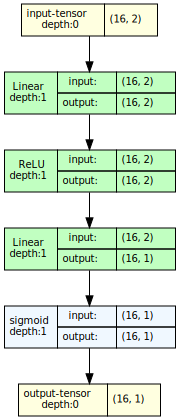

In [127]:
model_0 = SimpleNN(2, 1).to(device)
model_graph = draw_graph(model_0, input_size=(BATCH_SIZE, 2), device=device)
model_graph.visual_graph


### 4. Forward Pass

Perform a forward pass through the network using the input tensor.


In [128]:
input_tensor = torch.randn(16, 2, device=device)  # Random tensor with batch size 16 and 2 features
output = model_0(input_tensor)
print(output)

tensor([[0.5677],
        [0.6054],
        [0.5254],
        [0.6295],
        [0.6310],
        [0.5733],
        [0.6310],
        [0.5244],
        [0.5895],
        [0.6310],
        [0.6310],
        [0.5769],
        [0.6310],
        [0.6310],
        [0.6310],
        [0.6027]], device='cuda:0', grad_fn=<SigmoidBackward0>)



### 5. Define a Loss Function and Optimizer

Set up a loss function and an optimizer for training the neural network.


In [129]:
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification tasks
optimizer = optim.Adam(model_0.parameters(), lr=0.01)  # Stochastic Gradient Descent

In [130]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


### 6. Training Step

Simulate a simple training step.


In [131]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    total_train_loss, total_test_loss, train_batch_count, test_batch_count = 0, 0, 0, 0
    # Put model in training mode (this is the default state of a model)
    model_0.train()
    for i, (X_train, y_train) in enumerate(train_dataloader):
      X_train, y_train = X_train.to(device), y_train.to(device)
      # 1. Forward pass on train data using the forward() method inside
      y_pred_prob = model_0(X_train).squeeze()
      # print(y_pred)

      # 2. Calculate the loss (how different are our models predictions to the ground truth)
      loss = loss_fn(y_pred_prob, y_train)

      y_pred = torch.round(y_pred_prob) # preds
      acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred) # accuracy

      # 3. Zero grad of the optimizer
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Progress the optimizer
      optimizer.step()
      total_train_loss += loss.item()
      train_batch_count += 1

    avg_train_loss = total_train_loss/train_batch_count

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()
    with torch.inference_mode():
      for i, (X_test, y_test) in enumerate(test_dataloader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        # 1. Forward pass on test data
        test_pred = model_0(X_test).squeeze()

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
        total_test_loss += loss.item()
        test_batch_count += 1

      avg_test_loss = total_test_loss/test_batch_count


    # Print out what's happening
    if epoch % 10 == 0:
          epoch_count.append(epoch)
          train_loss_values.append(avg_train_loss)
          test_loss_values.append(avg_test_loss)
          print(f"Epoch: {epoch} | MAE Train Loss: {avg_train_loss} | MAE Test Loss: {avg_test_loss} ")


Epoch: 0 | MAE Train Loss: 0.36584351778030394 | MAE Test Loss: 0.3363962769508362 
Epoch: 10 | MAE Train Loss: 0.24428965717554094 | MAE Test Loss: 0.06356954574584961 
Epoch: 20 | MAE Train Loss: 0.22064081817865372 | MAE Test Loss: 0.3643593192100525 
Epoch: 30 | MAE Train Loss: 0.22493564397096633 | MAE Test Loss: 0.3563632667064667 
Epoch: 40 | MAE Train Loss: 0.22400015071034432 | MAE Test Loss: 0.4182109236717224 
Epoch: 50 | MAE Train Loss: 0.21812706157565118 | MAE Test Loss: 0.17915433645248413 
Epoch: 60 | MAE Train Loss: 0.2574528631567955 | MAE Test Loss: 0.10085900127887726 
Epoch: 70 | MAE Train Loss: 0.22419675946235657 | MAE Test Loss: 0.18875452876091003 
Epoch: 80 | MAE Train Loss: 0.24664442270994186 | MAE Test Loss: 0.23286068439483643 
Epoch: 90 | MAE Train Loss: 0.23152782201766967 | MAE Test Loss: 0.6584066152572632 


In [64]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


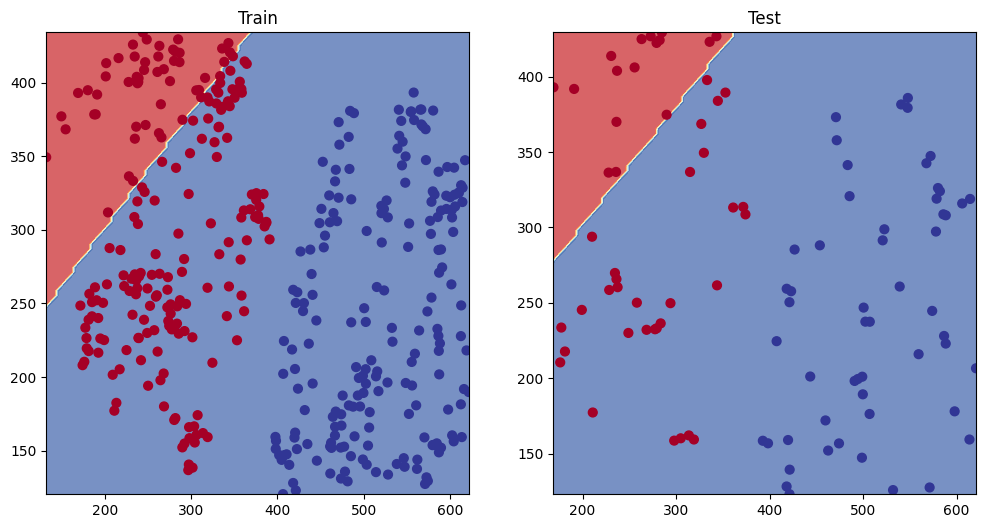

In [132]:
# Plot decision boundaries for training and test sets
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, train_data[:][0], train_data[:][1])
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, test_data[:][0], test_data[:][1])